# Diversity Aware Book Recommender
> A tutorial on building an amazon-like book recommender and keeping diversity as an important factor

- toc: true
- badges: true
- comments: true
- categories: [diversity, book]
- image: 

In [1]:
import math
import heapq

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [2]:
books_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/books.csv", encoding="ISO-8859-1")
books_tags_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/books_tags.csv", encoding="ISO-8859-1")
users_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/users.csv", encoding="ISO-8859-1")
ratings_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/ratings.csv", encoding="ISO-8859-1")
tags_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/tags.csv", encoding="ISO-8859-1")
test_df = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads/test.csv", encoding="ISO-8859-1")

In [3]:
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780440e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃÂÃÂ©",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780320e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780060e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780740e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [23]:
books_df.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'image_url',
       'small_image_url'],
      dtype='object')

In [24]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    5000 non-null   int64  
 1   goodreads_book_id          5000 non-null   int64  
 2   best_book_id               5000 non-null   int64  
 3   work_id                    5000 non-null   int64  
 4   books_count                5000 non-null   int64  
 5   isbn                       4764 non-null   object 
 6   isbn13                     4794 non-null   float64
 7   authors                    5000 non-null   object 
 8   original_publication_year  4993 non-null   float64
 9   original_title             4831 non-null   object 
 10  title                      5000 non-null   object 
 11  language_code              4621 non-null   object 
 12  image_url                  5000 non-null   object 
 13  small_image_url            5000 non-null   objec

In [4]:
books_tags_df.head()

,goodreads_book_id,tag_id
0,1,30574
1,1,11305
2,1,11557
3,1,8717
4,1,33114


In [5]:
users_df.head()

,user_id,location,age
0,1,North Dakota,69
1,2,California,24
2,4,Missouri,98
3,6,Rhode Island,66
4,8,Hawaii,64


In [6]:
ratings_df.head()

,user_id,book_id,rating
0,511,277,4
1,2766,54,5
2,2290,2499,2
3,3920,1603,5
4,2457,4,5


In [7]:
tags_df.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [8]:
test_df.head()

,user_id,book_id,rating
0,2558,1660,4
1,2694,1738,5
2,135,565,3
3,1074,337,5
4,727,4394,4


In [9]:
b_r_u_df = pd.merge(books_df[['book_id', 'title']], ratings_df, on='book_id', how='inner')
b_r_u_df = pd.merge(b_r_u_df, users_df, on='user_id', how='inner')
items_df = b_r_u_df[['book_id', 'title']].drop_duplicates(subset='book_id')
items_df.head()

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,4,To Kill a Mockingbird
2,5,The Great Gatsby
3,8,The Catcher in the Rye
4,17,"Catching Fire (The Hunger Games, #2)"


## Util functions

In [10]:
# Score for each book
def weighted_average_rating(counts_df, m, rating_mean_df, rating_all_mean):
    return (counts_df / (counts_df + m)) * rating_mean_df + (m / (counts_df + m)) * rating_all_mean


# To get the top k recommendations, the k books with the best score
def get_top_k_recommendations(df, counts_df, k, columns, m):
    return df[counts_df >= m].nlargest(k, columns)


# Get the top k recommendations: the k books with the best weighted average rating
def calculate_WAR_and_top_k(df, m, rating_all_mean, k, columns):
    df['weighted_average_rating'] = weighted_average_rating(df['counts'], m, df['rating_mean'], rating_all_mean)
    return get_top_k_recommendations(df, df['counts'], k, columns, m)


# Gets a number and creates the range of ages as required in the task
def get_age_range(age):
    if age % 10 == 0:
        age -= 1
    lower_bound = age - ((age % 10) - 1)
    upper_bound = age + (10 - (age % 10))
    return lower_bound, upper_bound


# Creates distribution of votes and ratings by book id and returns them
def merge_tables(df):
    # Dataframe that contains distribution of votes by book ID
    nb_voters_data = df['book_id'].value_counts()
    nb_voters_df = pd.DataFrame(data={'book_id': nb_voters_data.index.tolist(), 'counts': nb_voters_data.values.tolist()})

    # Dataframe that contains distribution of rate averages by book ID
    rating_mean_data = df.groupby(['book_id'])['rating'].mean()
    rating_mean_df = pd.DataFrame(data={'book_id': rating_mean_data.index.tolist(), 'rating_mean': rating_mean_data.values.tolist()})
    
    return nb_voters_df, nb_voters_data, rating_mean_df, rating_mean_data


# m represents the minimum voters we need to count the rating and the score
# We'll also need the total mean to caluculate the score (WR)
def get_voters_and_means(nb_voters_data, rating_mean_df):
    m = nb_voters_data.quantile(0.90)
    rating_all_mean = rating_mean_df['rating_mean'].mean()
    return m, rating_all_mean

## Non-personalized recommendations

In [11]:
# Calculate the WAR and get the k books with the best results
def get_simply_recommendation(k):

    nb_voters_df, nb_voters_data, rating_mean_df, rating_mean_data = merge_tables(b_r_u_df)
    m, rating_all_mean = get_voters_and_means(nb_voters_data, rating_mean_df)
    
    df = pd.merge(items_df, nb_voters_df, on='book_id', how='inner')
    df = pd.merge(df, rating_mean_df, on='book_id', how='inner')

    return calculate_WAR_and_top_k(df, m, rating_all_mean, k, ['weighted_average_rating'])


recommendation_df = get_simply_recommendation(10)
recommendation_df[['book_id','title','weighted_average_rating']].head(10)

,book_id,title,weighted_average_rating
504,25,Harry Potter and the Deathly Hallows (Harry Po...,4.338028
1,4,To Kill a Mockingbird,4.299843
506,102,Where the Wild Things Are,4.273212
370,85,The Giving Tree,4.240309
364,50,Where the Sidewalk Ends,4.239724
8,31,The Help,4.238851
425,144,"Unbroken: A World War II Story of Survival, Re...",4.221864
212,27,Harry Potter and the Half-Blood Prince (Harry ...,4.213906
0,1,"The Hunger Games (The Hunger Games, #1)",4.187383
663,133,"Anne of Green Gables (Anne of Green Gables, #1)",4.181489


In [12]:
# Calculate the WAR and get the k best books by a place
def get_simply_place_recommendation(place, k):
    global b_r_u_df
    
    b_r_u_place_df = b_r_u_df[b_r_u_df['location'] == place]
    
    nb_voters_df, nb_voters_data, rating_mean_df, rating_mean_data = merge_tables(b_r_u_place_df)
    m, rating_all_mean = get_voters_and_means(nb_voters_data, rating_mean_df)
    
    df = pd.merge(items_df, nb_voters_df, on='book_id', how='inner')
    df = pd.merge(df, rating_mean_df, on='book_id', how='inner')

    return calculate_WAR_and_top_k(df, m, rating_all_mean, k, ['weighted_average_rating'])


place_recommendation_df = get_simply_place_recommendation('Ohio', 10)
place_recommendation_df[['book_id','title','weighted_average_rating']].head(10)

,book_id,title,weighted_average_rating
310,126,Dune (Dune Chronicles #1),4.367963
602,143,All the Light We Cannot See,4.317786
356,144,"Unbroken: A World War II Story of Survival, Re...",4.266087
190,24,Harry Potter and the Goblet of Fire (Harry Pot...,4.249728
424,102,Where the Wild Things Are,4.226877
889,490,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.213664
1191,1462,The Orphan Master's Son,4.213664
1554,983,Between the World and Me,4.213664
884,119,The Handmaid's Tale,4.199565
800,89,The Princess Bride,4.190062


In [13]:
# Calculate the WAR and get the k best books by a range of ages
def get_simply_age_recommendation(age, k):
    global b_r_u_df
    
    lower_bound, upper_bound = get_age_range(age)
    b_r_u_age_df = b_r_u_df[(b_r_u_df['age'] >= lower_bound) & (b_r_u_df['age'] <= upper_bound)]
    
    nb_voters_df, nb_voters_data, rating_mean_df, rating_mean_data = merge_tables(b_r_u_age_df)
    m, rating_all_mean = get_voters_and_means(nb_voters_data, rating_mean_df)
    
    df = pd.merge(items_df, nb_voters_df, on='book_id', how='inner')
    df = pd.merge(df, rating_mean_df, on='book_id', how='inner')

    return calculate_WAR_and_top_k(df, m, rating_all_mean, k, ['weighted_average_rating'])


age_recommendation_df = get_simply_age_recommendation(28, 10)
age_recommendation_df[['book_id','title','weighted_average_rating']].head(10)

,book_id,title,weighted_average_rating
502,25,Harry Potter and the Deathly Hallows (Harry Po...,4.326251
1,4,To Kill a Mockingbird,4.294203
368,85,The Giving Tree,4.289614
948,89,The Princess Bride,4.244702
659,133,"Anne of Green Gables (Anne of Green Gables, #1)",4.224914
362,50,Where the Sidewalk Ends,4.216411
504,102,Where the Wild Things Are,4.204680
418,70,"Ender's Game (Ender's Saga, #1)",4.204095
8,31,The Help,4.202891
209,21,Harry Potter and the Order of the Phoenix (Har...,4.196385


## Collaborative filtering

In [14]:
# Get top K values from given array
def keep_top_k(array, k):
    smallest = heapq.nlargest(k, array)[-1]
    array[array < smallest] = 0
    return array


# Similirity matrix according to the chosen similarity
def build_CF_prediction_matrix(sim):
    global ratings_diff
    return 1-pairwise_distances(ratings_diff, metric=sim)


# Function that extracts user recommendations
# Gets the highest rates indexes and returns book id and the title for that user
def get_CF_final_output(pred, data_matrix, user_id, items_new_to_original, items, k):
    user_id = user_id - 1
    predicted_ratings_row = pred[user_id]
    data_matrix_row = data_matrix[user_id]
    
    predicted_ratings_unrated = predicted_ratings_row.copy()
    predicted_ratings_unrated[~np.isnan(data_matrix_row)] = 0

    idx = np.argsort(-predicted_ratings_unrated)
    sim_scores = idx[0:k]
    
    # When getting the results, we map them back to original book ids
    books_original_indexes_df = pd.DataFrame(data={'book_id': [items_new_to_original[index] for index in sim_scores]})
    return pd.merge(books_original_indexes_df, items, on='book_id', how='inner')

In [15]:
# Get the collaborative filtering recommendation according to the user
def get_CF_recommendation(user_id, k):
    # Import global variables
    global ratings_df
    global items_df

    # Declare of global variables
    global users_original_to_new
    global users_new_to_original
    global items_original_to_new
    global items_new_to_original
    global data_matrix
    global mean_user_rating

    # Part 1
    unique_users = ratings_df['user_id'].unique()
    unique_items = ratings_df['book_id'].unique()
    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    # Working on user data
    unique_users.sort()
    # Creating a dictionary that contains a mapping from original user id to a new user id
    users_original_to_new = {original_index: new_index for original_index, new_index in zip(unique_users, range(n_users))}
    # Creating a dictionary that contains a mapping from new user id to a original user id
    users_new_to_original = {value: key for key, value in users_original_to_new.items()}

    # Working on items data
    unique_items.sort()
    # Creating a dictionary that contains a mapping from original book id to a new book id
    items_original_to_new = {original_index: new_index for original_index, new_index in zip(unique_items, range(n_items))}
    # Creating a dictionary that contains a mapping from new book id to a original book id
    items_new_to_original = {value: key for key, value in items_original_to_new.items()}

    # Part 2
    data_matrix = np.empty((n_users, n_items))
    data_matrix[:] = np.nan
    for line in ratings_df.itertuples():
        user = users_original_to_new[line[1]]
        book = items_original_to_new[line[2]]
        rating = line[3]
        data_matrix[user, book] = rating

    mean_user_rating = np.nanmean(data_matrix, axis=1).reshape(-1, 1)

    global ratings_diff
    ratings_diff = (data_matrix - mean_user_rating)
    ratings_diff[np.isnan(ratings_diff)] = 0

    user_similarity = build_CF_prediction_matrix('cosine')
    user_similarity = np.array([keep_top_k(np.array(arr), k) for arr in user_similarity])
    pred = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

    # Part 3
    return get_CF_final_output(pred, data_matrix, user_id, items_new_to_original, items_df, k)

In [16]:
recommendations_by_user = get_CF_recommendation(user_id=1, k=10)
recommendations_by_user.head(10)

,book_id,title
0,101,Me Talk Pretty One Day
1,775,Just Kids
2,264,The Sun Also Rises
3,289,"Watership Down (Watership Down, #1)"
4,335,James and the Giant Peach
5,1084,To the Lighthouse
6,468,Their Eyes Were Watching God
7,184,Matilda
8,83,A Tale of Two Cities
9,344,Naked


## Content-based filtering

The features we used to work with are: language, tags, original title and authors.

We tried different features to choose the best ones. It seems logical that if we want a recommendation for Twilight or Harry Potter, or The Hunger Games, it will recommend us the other books of the Saga. That’s why the title’s book is important.

Moreover, usually, every author has its own writing style. We can see it through their different books. And if I liked a book of an author, I would like to get recommendations for its other books.

Language has also its logical impact. The way it’s been written, the language the lector speaks and language can also mean culture. French books are different from American books.

Tags give us some hints about the books: like the genre. It’s also important for the recommendation. We also tried with the publication year but it adds noises. It limits us. The year is taken as a string, so it’s either equal or different. That is not what we want.

In [17]:
# Preparing the dataframe for the algorithm
# Reading the tags and the relevant features and preparing the features for the algorithm
bookreads_tags_df = pd.merge(books_tags_df, tags_df, on='tag_id', how='inner')

groupped_data = bookreads_tags_df.groupby('goodreads_book_id', as_index=False)['tag_name'].transform(lambda x: ' '.join(x))
books_tags_row_df = pd.DataFrame(data={'goodreads_book_id': groupped_data.index.tolist(), 'tag_name': groupped_data['tag_name'].values.tolist()})

content_based_filtering_df = pd.merge(books_df[['book_id', 'title', 'authors', 'goodreads_book_id',  'language_code', 'original_title']], books_tags_row_df, on='goodreads_book_id', how='outer')
content_based_filtering_df['tag_name'] = content_based_filtering_df['tag_name'].fillna('')

In [18]:
# Clean the data to get lower case letter and get rid of '-'
def clean_data(x):
    x = str.lower(str(x))
    return x.replace('-', '')


# Get all of our features together with a space in between. The choice of the features is explained in the report.
def create_soup(x):
    return x['original_title'] + ' ' + x['language_code'] + ' ' + x['authors'] + ' ' + x['tag_name']


# Similarity matrix. We use cosine similarity
def build_contact_sim_metrix():
    global count_matrix
    return cosine_similarity(count_matrix, count_matrix)

In [22]:
# We return the top k recommendation according to the content (The features of each book)
def get_content_recommendation(book_name, k):
    global content_based_filtering_df

    features = ['original_title', 'language_code', 'authors', 'tag_name']
    for feature in features:
        content_based_filtering_df[feature] = content_based_filtering_df[feature].apply(clean_data)

    content_based_filtering_df['soup'] = content_based_filtering_df.apply(create_soup, axis=1)

    global count_matrix
    count_matrix = CountVectorizer(stop_words='english').fit_transform(content_based_filtering_df['soup'])

    cosine_sim = build_contact_sim_metrix()

    content_based_filtering_df = content_based_filtering_df.reset_index()
    indices = pd.Series(content_based_filtering_df.index, index=content_based_filtering_df['title'])

    idx = indices[book_name]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]

    book_indices = [i[0] for i in sim_scores]
    return content_based_filtering_df['title'].iloc[book_indices]

In [ ]:
content_based_filtering_result = get_content_recommendation('Twilight (Twilight, #1)', k=10)
content_based_filtering_result

## Evaluations

In [19]:
# Filter the data
# We want only the books with ratings >= 4 and the users that that ranked books at least 10 times
high_rate_test_df = test_df[test_df['rating'] >= 4]
user_value_counts = high_rate_test_df['user_id'].value_counts()
user_value_counts_df = pd.DataFrame(data={'user_id': user_value_counts.index.tolist(), 'appearances': user_value_counts.values.tolist()})
user_value_counts_df = user_value_counts_df[user_value_counts_df['appearances'] >= 10]

We get a weak precision_k for every similarity. The reason to this is that the test file is very small so it can’t give us a good precision. We don’t have enough information. We could have got better results for ARHR, but we didn’t for the same reasons. If we had more samples in our test file, the ARHR would be better. We still get better results than precision_k because we take into account the position of the books. Moreover, precision_k and ARHR, use only the top 10 recommendations that have been given. RMSE takes into account the predicted results and compare it to the actual one. Only the difference between the rankings matters. Those results show us that our rankings are good and that we succeeded to find the right rank of the recommendation (ARHR high).

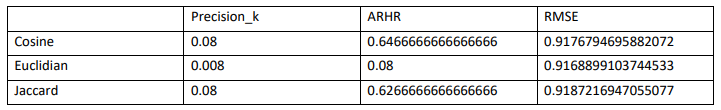

In [20]:
# Evaluation P@k for each similarity
def precision_k(k):
    # Importing global variables that has been assigned before to use them here
    global items_df
    global data_matrix
    global ratings_diff
    global mean_user_rating
    global items_new_to_original
    
    pk_list = []
    for sim in ['cosine', 'euclidean', 'jaccard']:
        calculations_list = []

        user_similarity = 1-pairwise_distances(ratings_diff, metric=sim)
        user_similarity = np.array([keep_top_k(np.array(arr), k) for arr in user_similarity])
        pred = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

        for user_id in user_value_counts_df['user_id'].values:
            user_recommendations = get_CF_final_output(pred, data_matrix, user_id, items_new_to_original, items_df, k)

            counter = 0
            for book_idx in user_recommendations['book_id'].values:
                chosen_book = high_rate_test_df[(high_rate_test_df['user_id'] == user_id) & (high_rate_test_df['book_id'] == book_idx)]
                if chosen_book.shape[0] == 1:
                    counter += 1

            calculations_list.append(counter / k)

        pk_list.append(sum(calculations_list) / user_value_counts_df.shape[0])

    return pk_list


print(precision_k(10))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


[0.08, 0.008, 0.08]


In [21]:
# Evaluation ARHR
def ARHR(k):
    # Importing global variables that has been assigned before to use them here
    global items_df
    global data_matrix
    global ratings_diff
    global mean_user_rating
    global items_new_to_original
    
    arhr_list = []
    for sim in ['cosine', 'euclidean', 'jaccard']:
        calculations_list = []

        user_similarity = 1-pairwise_distances(ratings_diff, metric=sim)
        user_similarity = np.array([keep_top_k(np.array(arr), k) for arr in user_similarity])
        pred = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

        for user_id in user_value_counts_df['user_id'].values:
            user_recommendations = get_CF_final_output(pred, data_matrix, user_id, items_new_to_original, items_df, k)

            user_high_rate_df = high_rate_test_df[high_rate_test_df['user_id'] == user_id]
            user_rec_merged_df = pd.merge(user_recommendations, user_high_rate_df, on='book_id', how='inner')

            for position in user_rec_merged_df.index + 1:
                calculations_list.append(1 / position)

        arhr_list.append(sum(calculations_list) / user_value_counts_df.shape[0])

    return arhr_list


ARHR(10)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


[0.6466666666666666, 0.08, 0.6266666666666666]

In [22]:
# Helper function to build the function RMSE. This time we wont filter the data.
def get_recommendations_RMSE(pred, data_matrix, user_id):
    user_id = user_id - 1
    predicted_ratings_row = pred[user_id]
    data_matrix_row = data_matrix[user_id]

    predicted_ratings_unrated = predicted_ratings_row.copy()
    predicted_ratings_unrated[~np.isnan(data_matrix_row)] = 0

    book_ids = np.argsort(-predicted_ratings_unrated)
    books_rating = np.sort(predicted_ratings_unrated)[::-1]

    return {idx: rating for idx, rating in zip(book_ids, books_rating)}


# Evaluation RMSE.
def RMSE():
    # Importing global variables that has been assigned before to use them here.
    global ratings_diff
    global mean_user_rating
    
    rmse_list = []
    for sim in ['cosine', 'euclidean', 'jaccard']:
        sum_error = 0
        count_lines = 0

        user_similarity = 1-pairwise_distances(ratings_diff, metric=sim)
        pred = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

        for user_id, test_user_data in test_df.groupby('user_id'):
            user_recommendations = get_recommendations_RMSE(pred, data_matrix, user_id)

            for row in test_user_data.itertuples(index=False):
                _, test_book_id, rating = tuple(row)
                prediction = user_recommendations[test_book_id] if test_book_id in user_recommendations else 0

                if prediction == 0:
                    continue

                sum_error += (prediction - rating)**2
                count_lines += 1

        rmse_list.append(math.sqrt(sum_error/count_lines))

    return rmse_list
    
    
RMSE()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


[0.9176794695882072, 0.9168899103744533, 0.9187216947055077]